In [1]:
%pylab inline
import random

Populating the interactive namespace from numpy and matplotlib


#Aufgabenblatt 6
##2. Simulation von Waldbränden

Simulieren Sie die Ausbreitung von Waldbränden: auf dem 2-dimensionalen quadratischen Gebiet der Größe $L \times L$ können Bäume mit einer Wahrscheinlichkeit $p_G$ pro Zeiteinheit wachsen. Auf dem Gebiet können Gewitter entstehen und Bäume (d.h. besetzte Gitterstellen) werden mit einer Wahrscheinlichkeit $p_L$ in Brand gesetzt. Die Bäume geben ihr Feuer in jedem Schritt an ihre nächsten Nachbarn weiter und sterben dann ab. 

Es gibt also drei Zustandsgrößen:

0. kein Baum bzw. abgestorbener Baum
1. gesunder Baum
2. brennender Baum

**a.)** Simulieren Sie Systeme mit Größe $L=40$ und $L=100$ sowie Wahrscheinlichkeiten $p_G= 0.01$ und $p_L = 0.0001$.

**b.)** Wie entwickelt sich die Clustergröße der Bäume

**c.)** Wie entwickelt sich die Clustergröße der Freiflächen?

In [2]:
class Wald:
    def __init__(self, L, pG, pL):
        self.L = L
        self.pG = pG
        self.pL = pL
        self.feld = np.zeros([L,L], dtype=np.int8)
        #Starte mit 20% Bäumen
        self.feld[np.where(np.random.random([self.L, self.L]) < 0.2)] = 1
        self._clusters = None
        self._clusterSizes = None
    def timestep(self):
        self._clusters = None
        self._clusterSizes = None
        #Für jedes Feld eine Zufallszahl anfordern.
        zufall = np.random.random([self.L, self.L])
        #Feld ist leer und neuer baum wächst
        self.feld[np.where(np.logical_and(self.feld == 0, zufall < self.pG))] = 1
        #Gesunder Baum gerät in Brand
        lebendigeBäume = self.feld == 1
        self.feld[np.where(np.logical_and(lebendigeBäume, zufall < self.pL))] = 2
        
        brennendeBäume = self.feld == 2
        hatBrennendenNachbarn = nachbarn(brennendeBäume)
        #Brennende Bäume verschwinden
        self.feld[brennendeBäume] = 0
        #Gesunder baum und hatte brennenden nachbarn
        self.feld[np.where(np.logical_and(lebendigeBäume,hatBrennendenNachbarn))] = 2
        #Ausformulierter langsamer Algorithmus, bevor ich numpy richtig benutzt habe:
        """for i in range(self.L):
            for j in range(self.L):
                if self.feld[i,j] == 0:
                    if random.uniform(0, 1) < self.pG:
                        #Feld ist leer und neuer baum wächst
                        self.feld[i,j] = 1
                elif self.feld[i,j] == 1:
                    #Gesunder Baum gerät in Brand
                    if random.uniform(0, 1) < self.pL:
                        self.feld[i,j] = 2
                else:
                    #Brennender Baum steckt nachbarbäume an
                    if 0 < i and self.feld[i-1,j] == 1:
                        self.feld[i-1,j] = 2
                    if i < self.L - 1 and self.feld[i + 1,j] == 1:
                        self.feld[i+1,j] = 2
                    if 0 < j and self.feld[i,j - 1] == 1:
                        self.feld[i,j - 1] = 2
                    if j < self.L - 1 and self.feld[i,j + 1] == 1:
                        self.feld[i,j + 1] = 2
                #TODO: HIER FEHLT DAS AUSBRENNEN VON BÄUMEN!"""
def nachbarn(feld):
    """Erhalte die OR-Verknüpfung aller Nachbarn aller Felder"""
    result = np.empty(feld.shape, dtype=bool_)
    #Initialisieren mit 0
    result[-1, :].fill(False)
    result[0:-1, :] = feld[1:, :]
    result[1:, :] |= feld[0:-1, :]
    result[:, 0:-1] |= feld[:, 1:]
    result[:, 1:] |= feld[:, 0:-1]
    return result
def findClusters(gitter, L):
    clusters = np.zeros(shape=(L, L), dtype=np.int32)
    clusterSizes = []
    for i in range(L):
        for j in range(L):
            if clusters[i,j] == 0 and gitter[i,j]:
                #Gitterpunkt ist gesetzt, aber Cluster noch nicht. Starte Cluster hier
                cluster, clusterSize = findCluster(gitter, L, i, j)
                clusterSizes.append(clusterSize)
                clusterId = len(clusterSizes)
                clusters[np.where(cluster)] = clusterId
    return clusters, clusterSizes

#Versuch findCluster zu beschleunigen: Wir betrachten nur einen Ausschnitt um den Start-Punkt mit einem Radius
def radius(feld, i, j, r):
    return feld[max(0, i - r):min(feld.shape[0], i + r + 1), 
                max(0, j - r):min(feld.shape[1], j + r + 1)]

def findCluster(gitter, L,  i, j):
    #Finde Cluster beginnend bei i,j
    feld = np.zeros([L,L], dtype=np.bool_)
    feld[i, j] = True
    count = 0
    newCount = 1
    r = 1
    while newCount > count:
        #Siehe radius
#        feld[max(0, i - r):min(feld.shape[0], i + r + 1), 
#             max(0, j - r):min(feld.shape[1], j + r + 1)] |= np.logical_and(nachbarn(radius(feld, i, j, r)), radius(gitter, i, j, r))
        feld |= np.logical_and(nachbarn(feld), gitter)
        count = newCount
        newCount = np.count_nonzero(feld)
        r += 1
    return feld, newCount

def generateData(csizesBaum, csizesFrei, out):
    #Erzeuge Max/Mean/Std aus Listen von Cluster Größen
    if len(csizesBaum) == 0:
        out[0] = 0
        out[1] = 0
        out[2] = 0
    else:
        csizes = np.array(csizesBaum)
        out[0] = np.max(csizes)
        out[1] = np.mean(csizes)
        out[2] = np.std(csizes)
    
    if len(csizesFrei) == 0:
        out[3] = 0
        out[4] = 0
        out[5] = 0
    else:
        csizes = np.array(csizesFrei)
        out[3] = np.max(csizes)
        out[4] = np.mean(csizes)
        out[5] = np.std(csizes)
        
#    if len(csizesBrennend) == 0:
#        out[6] = 0
#        out[7] = 0
#        out[8] = 0
#    else:
#        csizes = np.array(csizesBrennend)
#        out[6] = np.max(csizes)
#        out[7] = np.mean(csizes)
#        out[8] = np.std(csizes)

In [3]:
%%time

pG = 0.01
pL = 0.0001
N2 = 1
experimente = {50:[Wald(50, pG, pL) for _ in range(N2)], 100:[Wald(100, pG, pL) for _ in range(N2)]}
N = 200

timesteps = np.empty([2, 9, N])
baumCount = np.empty([len(experimente), N2, N])
brennenderBaumCount = np.empty([len(experimente), N2, N])
freiFlaecheCount = np.empty([len(experimente), N2, N])
#Verschiedene Experimente
for i, L in enumerate(experimente):
    #N Zeitschritte
    for t in range(N):
        #Kombiniere alle Clustergrößen aller Einzelexperimente.
        clusterSizesBaum = []
        clusterSizesFrei = []
#        clusterSizesBrennend = []
        #Bilde durchschnitt über N2 Einzelexperimente
        for j, experiment in enumerate(experimente[L]):
            #Simuliere
            experiment.timestep()
            
            #Alle freiflächen
            freiFlaeche = experiment.feld == 0
            _, csizes = findClusters(freiFlaeche, L)
            clusterSizesFrei.extend(csizes)

            #Alle gesunden Bäume
            gesundeBaeume = experiment.feld == 1
            _, csizes = findClusters(gesundeBaeume, L)
            clusterSizesBaum.extend(csizes)
            
            #Alle brennenden Bäume
            brennendeBaueme = experiment.feld == 2
#            _, csizes = findClusters(brennendeBaueme, L)
#            clusterSizesBrennend.extend(csizes)

            #Zähle bäume/freiflächen 
            freiFlaecheCount[i, j, t] = np.count_nonzero(freiFlaeche)
            baumCount[i, j, t] = np.count_nonzero(gesundeBaeume)
            brennenderBaumCount[i, j, t] = np.count_nonzero(brennendeBaueme)
        #Schreibe Max/Mean/Std für bäume und freiflächen-Cluster in array.
        generateData(clusterSizesBaum, clusterSizesFrei, timesteps[i, :, t])


Wall time: 41.3 s


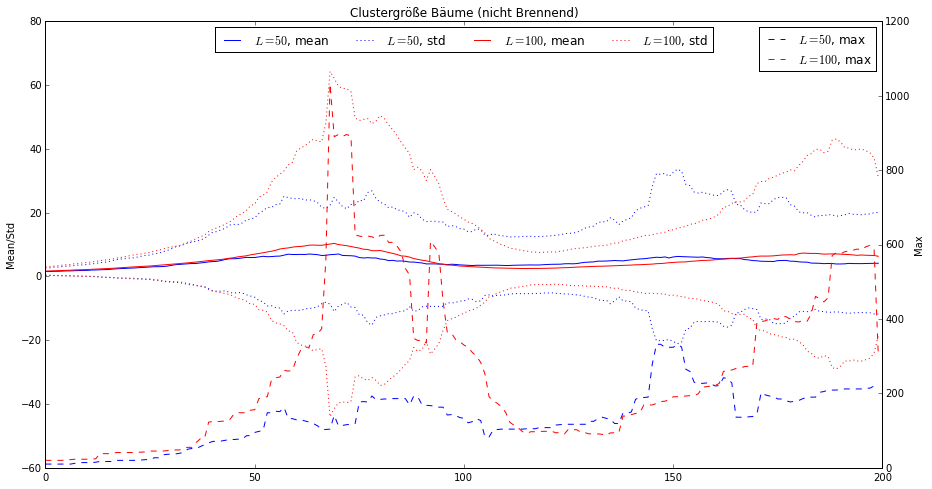

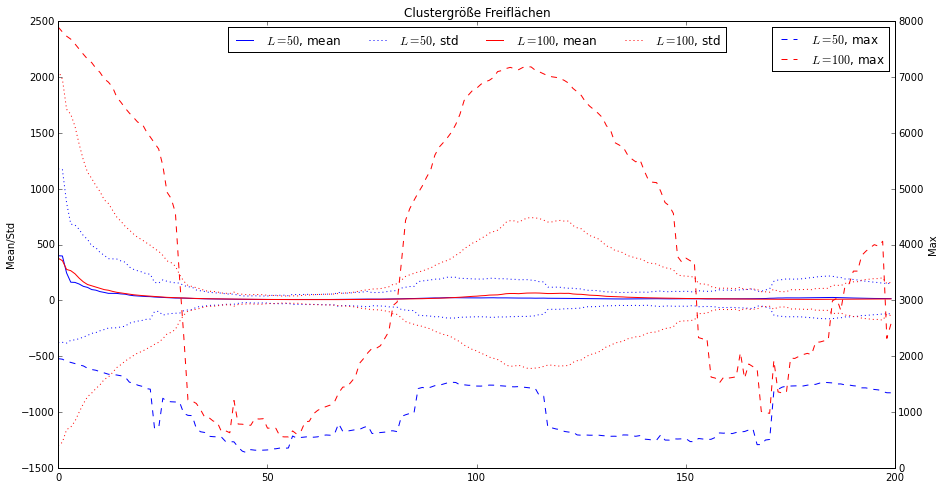

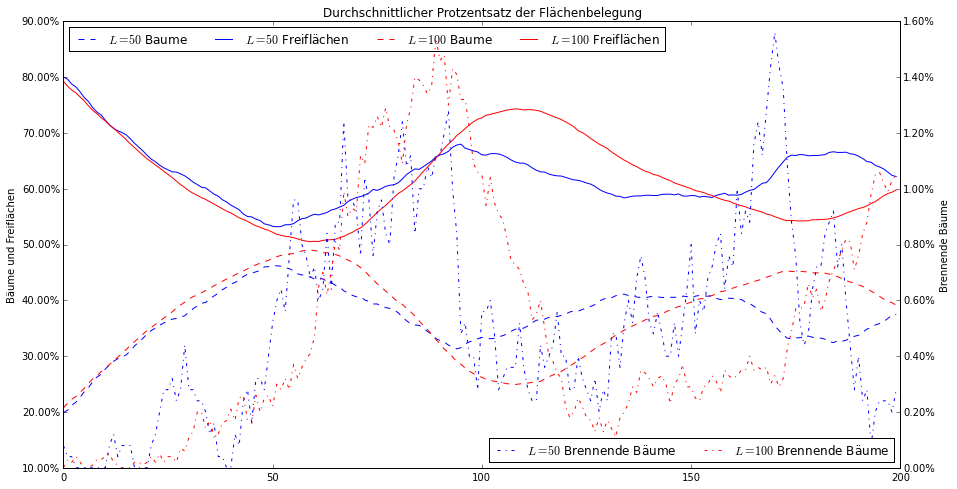

In [4]:
pylab.rcParams['figure.figsize'] = (15, 8)

def plotMaxMeanStd(L, data, c, ax1, ax2):
    ax1.plot(range(N), data[1],           "-", color = c, label = "$L=%d$, mean" % L)
    ax1.plot(range(N), data[1] - data[2], ":", color = c, label="$L=%d$, std" % L)
    ax1.plot(range(N), data[1] + data[2], ":", color = c)
    ax2.plot(range(N), data[0],          "--", color = c, label = "$L=%d$, max" % L)

c = ['blue', 'red', 'black', 'yellow']

def plotClustergroesse(data, a, b, title):
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax2 = ax1.twinx()
    for i, L in enumerate(experimente):
        plotMaxMeanStd(L, data[i, a:b, :], c[i%len(c)], ax1, ax2)
    ax1.legend(ncol=4, loc='upper center')
    ax2.legend(loc=0)
    ax1.set_ylabel("Mean/Std")
    ax2.set_ylabel("Max")
    plt.show()

plotClustergroesse(timesteps, 0, 3, "Clustergröße Bäume (nicht Brennend)")
plotClustergroesse(timesteps, 3, 6, "Clustergröße Freiflächen")

#pylab.yscale('log')
fig, ax1 = plt.subplots()
ax1.set_title("Durchschnittlicher Protzentsatz der Flächenbelegung")
ax2 = ax1.twinx()
formatter = FuncFormatter(lambda y,p: "%.02f%%" % (100*y))
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax1.set_ylabel("Bäume und Freiflächen")
ax2.set_ylabel("Brennende Bäume")
for i, L in enumerate(experimente):
    ax1.plot(range(N), baumCount[i].mean(0)/(L**2), "--", label="$L=%d$ Baume" % L, color=c[i%len(c)])
    ax2.plot(range(N), brennenderBaumCount[i].mean(0)/(L**2), "-.", label="$L=%d$ Brennende Bäume" % L, color=c[i%len(c)])
    ax1.plot(range(N), freiFlaecheCount[i].mean(0)/(L**2), label="$L=%d$ Freiflächen" % L, color=c[i%len(c)])
_ = ax1.legend(ncol=6, loc='upper left')
_ = ax2.legend(ncol=6, loc='lower right')

# Tests für Cluster finden

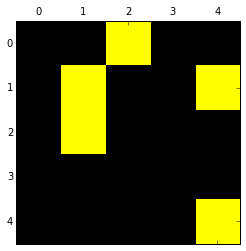

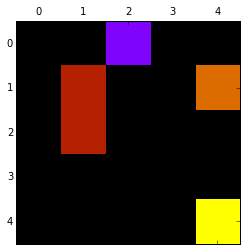

In [5]:
pylab.rcParams['figure.figsize'] = (6, 4)

test1 = np.random.uniform(size=[5,5]) < 0.25

clusters, clusterSizes = findClusters(test1, 5)
pylab.matshow(test1, cmap=cm.gnuplot)
pylab.show()
pylab.matshow(clusters, cmap=cm.gnuplot)

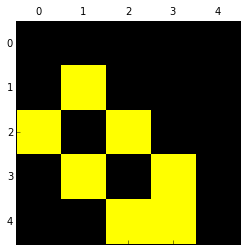

[[0 0 0 0 0]
 [0 1 0 0 0]
 [2 0 3 0 0]
 [0 4 0 5 0]
 [0 0 5 5 0]]


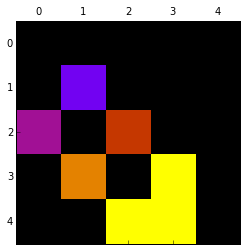

In [6]:
test2 = np.array([[False, False, False, False, False],
 [False,  True, False, False, False],
 [ True, False,  True, False, False],
 [False,  True, False,  True, False],
 [False, False,  True,  True, False]])

clusters, clusterSizes = findClusters(test2, 5)
pylab.matshow(test2, cmap=cm.gnuplot)
pylab.show()
pylab.matshow(clusters, cmap=cm.gnuplot)
print(clusters)